In this code I try to find the correct parameters to allow the neural network to learn how to balance a pole on a cart. The choices for the parameters and nodes are based on making sure that the time for the algorithm isn't too long, that the network learns how to balance after not too many attempts and that it maintains this ability throughout all runs. For the last point i noticed that often the network would reach a peak and then decline in the amount of events per run. 

In the final graph you can see how it improved per each run, this is the blue line. In orange you see a 7 run moving average. What this means is that the mean of 7 datapoints are taken and assigned to the middle data point. This will be also explained in the code.

I will try to explain my adjustments to any code in red

In [0]:
#!pip install gym

# GYM provides an environment for an agent to interact with. We'll look at the 'cartpole',
#  or the unstable, top-heavy inverted pendulum on top of a cart, which our 'agent' must learn to balance.
#
# GYM provides:
#  - a state (observation) of the system/environment
#    (in case of cartpole: cart position and velocity, angle and velocity at the tip
#  - a set of _actions_ the agent can undertake in the environment
#    (in case of cartpole: moving the cart base left or right)

# When an agent performs a certain action in the current enviroment, GYM returns
#  - a _reward_ for a certain result of performing the action in the environment
#    (in case of cartpole: +1 if it didn't die.)
#  - the new _state_ of the environment after performing said action
#    (in case of cartpole: the effect of gravity pulling on the pendulum's top, on the angle, in one time step)
#  - a 'terminal' in case the state is such that the agent cannot continue (is 'dead')
#    (in case of cartpole: if the angle exceeds > 5 degrees of tipping over, or it flies off-screen)

# It is up to us to make an agent that learns which action to take in which state, to maximise the total reward before it dies.
#  We do this by 'remembering' what the results were of certain actions on certain states in a memory (i.e. a list or deque),
#  And after every 'death' we sample ('replay') from this memory to train a neural network that decides the best actions
#   we can take on any state we've encountered so far, which maximises the total reward.

# In addition, GYM provides a nice real-time visual output of the environment and the result of actions taken.
#  In google COLAB however, we pull some strings, and only have a combined video at the end.


In [0]:
COLAB = True

if(COLAB) :
  # install some helpers to visualize gym graphics in the colab environment
  !pip install gym pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg x11-utils > /dev/null 2>&1

In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt
import random

from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
# only necessary for visualisation in colab env.
if(COLAB) :
  from IPython.display import HTML
  from IPython import display as ipythondisplay
  from pyvirtualdisplay import Display
  from gym.wrappers import Monitor
  import glob, io, os, base64
  from moviepy.editor import VideoFileClip, concatenate_videoclips

  display = Display(visible=0, size=(1400, 900))
  display.start()
  os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

  def combine_videos() :
    mp4list = sorted( glob.glob('video/*.mp4') )
    if len(mp4list) > 0 :
      videolist = []
      for mp4 in mp4list :
        videolist.append( VideoFileClip(mp4))
      final_clip = concatenate_videoclips(videolist)
      final_clip.to_videofile("combined.mp4", fps=24, remove_temp=False)
      return 1
    else :
      return 0

  def show_video() :
      if(combine_videos()) :
        video = io.open("combined.mp4", 'r+b').read()

        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
               </video>'''.format(encoded.decode('ascii'))))
      else :
        print("Error: no videos found")     


  def wrap_env(env):
    env = Monitor(env, './video', video_callable=lambda episode_id: True, force=True)
    return env


In [0]:
ENV_NAME = "CartPole-v1"

### STUDENT CODE HERE ###
### --> Change the parameters below to perform a better training

'Here I changed the 50 runs to 100, as to see how the network can maintain its high scores.'
'By doing this i noticed that my originally good network would collape after a while'
MAXRUNS = 100
#NSTEPSOLVED = 1000

'I increased the gamma to 0.995. What the gamma does is determine how future trials will differ from the present one,'
'the higher it is, the smoother you will expect your curve to be.'
'The learning rate i increase as well as i noticed that it would only learn after a 50-60 trials. Now around 30 runs it starts to increase.'
GAMMA = 0.995  # 'future discount factor'
LEARNING_RATE = 0.001 # rate at which to update weights after each training step

'Memory size was also increased, what this does is increase the "list" holding memories of action made in previous runs.' 
'By increasing the network will learn better but the algorithm will take longer.'
'Batch size is the amount of events from the previous run that will be replayed and learnt from.'
'The higher the number the more it will learn from previous runs'
MEMORY_SIZE = 1000000 # size of container to hold actions and outcomes
BATCH_SIZE = 50 # number of actions in memory to 'replay' after each death

'Here only the exploration decay is changed. It is increased as it quickly reached the minimum before.'
'The exploration allows for random actions to occur, and so by increasing the decay more random actions are made, so that it could learn from these actions.'
'This will mean that the curve will be less smooth.'
# probability to do 'random' actions, to sample from event space
EXPLORATION_MAX = 1.0  
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.998  



In [0]:
class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        # This will be a simple feed-forward NN, with 
        #  - input = 'observation' (aka state)
        #  - output = predicted 'quality' of each possible action
        self.model = Sequential()
        
        ### STUDENT CODE HERE ###
        ### --> Write the network using fully-connected (Dense) layers.
        ###  Make sure the input has the same shape as an observation/state,
        ###   and the output has the same dimensions as the number of possible actions.
        'Here i added the layers with a final output which is the same as the number of possible actions.'
        'I also tried with sigmoid activation but the system did not seem to learn that well with this function.'
        'Adding more also seemed to work against the overall objective, as it is slower and the learning did not improve.'
        self.model.add(Dense(units=30, activation='relu', input_shape=(observation_space,) ))
        self.model.add(Dense(units=30, activation='relu', input_shape=(observation_space,) ))
        self.model.add(Dense(units=self.action_space, activation='linear'))
        ### END STUDENT CODE ###
        
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))
        self.model.summary()
        
    def remember(self, state, action, reward, next_state, done):
        # add event to memory
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # return the best possible action for the current state

        # sometimes allow for a random action at the 'exploration rate', to avoid local minima
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        
        # Get predicted qualities for each possible action, and return the action (=index) with the highest quality
        q_values = self.model.predict(state) 
        return np.argmax(q_values[0])

    def experience_replay(self):
        # Learn from random subset of memory (reduces corr. between subsequent actions).
        # learning is done by comparing 'predicted quality' to the here defined quality (~reward) of the action.
        
        if len(self.memory) < BATCH_SIZE:
            # We haven't experienced enough to properly learn yet - keep exploring!
            return
        
        # Get random subset of memory
        batch = random.sample(self.memory, BATCH_SIZE) 
        
        for state, action, reward, state_next, terminal in batch:

            # We define the 'quality' of a move by taking the known, memorized reward for the action,
            #  and adding the predicted quality of the (predicted) best choice of action for the next state, to that.
            # As the model learns to give this situation a low quality, any step leading up to this state will get a 
            #  lower quality due to the predict(state_next) term. This will slowly trickle through to the step before that, etc.,
            #  slowly making our agent learn about future consequences of current actions.
          
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
                
                # One could try to make the model learn from intermediate steps directly as well, speeding up the learning,
                #  e.g. by changing the reward based on an increase in angle (although this should really be defined in the env.)
                #q_update -= 1.0 * abs(state_next[0][2]) - abs(state[0][2]) # penalize angle increases for cartpole
                
            # - Define the quality of the non-chosen action to just be the predicted quality (i.e. diff = 0)
            # - Define the quality of the chosen action to be the newly defined quality
            q_values = self.model.predict(state)
            q_values[0][action] = q_update 
            
            # Finally, find the optimal model weights for minimal difference between 
            #  predicted quality and observed quality (+ future prediction as per above) for this action.
            # The weights are then updated * learning rate
            self.model.fit(state, q_values, verbose=0) 
            
        # reduce the 'random choices' rate over time, because you expect the model to have learned
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

In [0]:
def cartpole() :
    if(COLAB) : env = wrap_env(gym.make(ENV_NAME)) # only for visualisation in colab
    else : env = gym.make(ENV_NAME)

    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)
       
    run=0
    runsteplog = []
    #while True:
    for i in range(MAXRUNS):
        run += 1
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        
        while True :    
            step += 1
            screen = env.render() # graphical output


            ''
            ### STUDENT CODE HERE
            ### --> Redefine the action to be the output of the 'act' of your solver.
            'Here the code is adjusted aso that the action is the output of the act of the state. '
            'Before it was a random act but now it based on the state'
            action = dqn_solver.act(state)
            ### END STUDENT CODE
            
            # make the action
            state_next, reward, terminal, info = env.step(action) 

            # if action made terminal: reduce reward!
            reward = reward if not terminal else -reward  

            state_next = np.reshape(state_next, [1, observation_space])

            # fill agent memory with this action's results
            dqn_solver.remember(state, action, reward, state_next, terminal) 

            # prepare for the next action in the environment
            state = state_next 
            
            if terminal :
                #state = env.reset()
                #state = np.reshape(state, [1, observation_space])
                print("Run: {0}, exploration: {1:.15f}, score: {2}".format(run,dqn_solver.exploration_rate,step))
                runsteplog += [step]

                break
            
            dqn_solver.experience_replay() # learn from batch of memories every time a new one is made
            
            #if(step > NSTEPSOLVED) :
            #    i = MAXRUNS
            #    print("Solved! (step > NSTEPSOLVED)")
            #    break


    env.close()
    


    # Show training process
    
    # plot #steps achieved
    plt.plot(runsteplog)
    plt.ylabel("# actions before terminal")
    plt.xlabel("run iteration")

    success_measure = np.mean(runsteplog[-15:])
    print("Mean of last 15 runs: {0}".format(success_measure))

    'The following code was added to create a plot of the running average of 7 runs.' 
    'First two arrays are created cumsum and moving_aves, and in the loop the data from runsteplog is then assigned to cumsum.'
    'Then for any data point equal or larger than N (cannot be smaller as the index for the next equation would be below zero) they add up all points between i-N and N divide this by N, giving the mean.'
    'This is then added to a new data set moving_aves and plotted. You can see it in the graph below in orange'
    'The point of this is too smooth the curve and see the overal trend that the network is following.'
    'The code was taken from the following link: https://stackoverflow.com/questions/13728392/moving-average-or-running-mean'
   
    N = 7
    cumsum, moving_aves = [0], []

    for i, x in enumerate(runsteplog, 1):
      cumsum.append(cumsum[i-1] + x)
      if i>=N:
          moving_ave = (cumsum[i] - cumsum[i-N])/N
          #can do stuff with moving_ave here
          moving_aves.append(moving_ave)

    plt.plot(moving_aves)

    return success_measure

  






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                150       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 62        
Total params: 1,142
Trainable params: 1,142
Non-trainable params: 0
_________________________________________________________________
Run: 1, exploration: 1.000000000000000, score: 18
Run: 2, exploration: 1.000000000000000, score: 18
Run: 3, exploration: 1.000000000000000, score: 10








Run: 4, exploration: 0.974309723398926, score: 17
Run: 5, exploration: 0.939824538049636, score: 19
Run: 6, exploration: 0.879740614751579, score: 34
Run: 7, exploration: 0.850303260282521, score: 18
Run: 8, exploration:

100%|██████████| 6666/6666 [00:42<00:00, 165.26it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: combined.mp4 



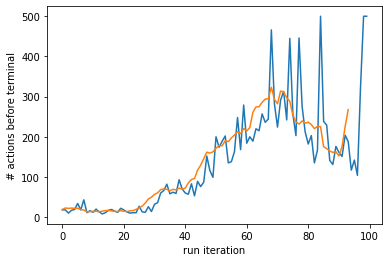

In [7]:
MAXRUNS = 100

if __name__ == "__main__":
    cartpole()

if(COLAB) :
    show_video() 